# Investigate filestructure and images for correct labelling

<b> What data do we have now? <b>

1. Stimulated 14h (or 16h) -> labelled as 0
2. Unstimulated -> labelled as 1
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data]) -> labelled as 2
4. Stimulated timecourse data -> labelled as 3
5. EI24 KO timecourse data (more similar to unstim) -> labelled as 4
6. Screening data (similar to stim) -> labelled as 5


<b> What are we doing in this section? <b>

This notebook investigates the filestructure we have and visualizes the images for all bioloical classes we have as an overview.


In [1]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn
!pip install leidenalg
!pip install scanpy==1.9.6
!pip install anndata umap-learn
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=b417512374adce2639e295f38c5c73b3a671c89c1661938798f7853cfba8f680
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3c5t4rp/wheels/6a/11/c0/30d81aa26172d10d68ffaf352b0762eb9fe0a5f5dcf3de63e0
Successfully built torch-intermediate-layer-getter
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bi

In [2]:
%load_ext watermark
import os
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad
import re
from collections import Counter
import random
from torch.utils.data import Subset
import h5py
import random
import pickle
import glob

from sparcscore.ml.datasets import HDF5SingleCellDataset
# from sparcscore.pipeline.project import TimecourseProject, Project
# from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


In [5]:
%watermark -v -iv -m -p os,wandb,numpy,seaborn,matplotlib,tqdm,pandas,torch,sklearn,sys,seaborn,tensorboard,umap-learn,scanpy,anndata,sparcscore

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

os         : unknown
wandb      : 0.15.9
numpy      : 1.23.5
seaborn    : 0.12.2
matplotlib : 3.7.1
tqdm       : 4.65.0
pandas     : 1.5.2
torch      : 2.1.0a0+4136153
sklearn    : 1.2.0
sys        : 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
tensorboard: 2.9.0
umap-learn : not installed
scanpy     : 1.9.6
anndata    : 0.10.9
sparcscore : 1.0.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.0-1065-nvidia
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

torch_intermediate_layer_getter: 0.1.post1
sklearn                        : 1.2.0
numpy                          : 1.23.5
wandb                          : 0.15.9
tqdm                           : 4.65.0
anndata                        : 0.10.9
scanpy                         : 1.9.6
h5py                           : 3.9.0
torch                          : 2.1.0a0+4136153
matplotlib                

## I. Investigate filestructure <a class="anchor" id="filestructure"></a>

First, we want to look at where we have the data stored and how many slides, i.e. files, we have and then we create a test set containing instances from all biological classes:

* Screen single cell images from 6 different slides are here: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/
* Three replicates of single cell image EI24 KO timecourse data are now in /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/
* The rest is here: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/

In [13]:
# Screen single cell images from 6 different slides
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/')
files = os.listdir()
print("Files in 231004_autophagy_screen_6slides:")
for file in files:
    print(file)
print("\n")

Files in 231004_autophagy_screen_6slides:
2.3_A002
2.3_K001
2.3_H002
2.3_F003
2.3_B004
2.3_D001




In [6]:
# 3 replicates of single cell image EI24 KO timecourse data
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/')
files = os.listdir()
print("Files in 231018_EI24_timecourse_phenix:")
for file in files:
    print(file)
print("\n")

Files in 231018_EI24_timecourse_phenix:
231018_0318_EI24_fixed_tc
231018_0317_EI24_fixed_tc
231018_0316_EI24_fixed_tc




In [7]:
# Rest
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/')
files = os.listdir()
print("Files in 230714_autophagy_training_data_sample:")
for file in files:
    print(file)
print("\n")

Files in 230714_autophagy_training_data_sample:
T_01_stim_wt_filtered.h5
T_01_unstim_wt_filtered.h5
T_02_unstim_wt_filtered.h5
T_02_stim_wt_filtered.h5
T_2.2_stim_wt_filtered.h5
T_2.X_stim_wt_filtered.h5
T_02_stim_Cr203_C6_filtered.h5
T_2.2_stim_Cr203_filtered.h5
T_2.X_stim_Cr203_filtered.h5
T_2.3_stim_Cr203_filtered.h5
T_2.3_stim_wt_filtered.h5
T_01_stim_Cr203_C6_filtered.h5




In [10]:
# Count occurrences of each file type
files = [
    "T_01_stim_wt_filtered.h5",
    "T_01_unstim_wt_filtered.h5",
    "T_02_unstim_wt_filtered.h5",
    "T_02_stim_wt_filtered.h5",
    "T_2.2_stim_wt_filtered.h5",
    "T_2.X_stim_wt_filtered.h5",
    "T_02_stim_Cr203_C6_filtered.h5",
    "T_2.2_stim_Cr203_filtered.h5",
    "T_2.X_stim_Cr203_filtered.h5",
    "T_2.3_stim_Cr203_filtered.h5",
    "T_2.3_stim_wt_filtered.h5",
    "T_01_stim_Cr203_C6_filtered.h5"
]

def extract_file_type(file_name):
    match = re.search(r'_(stim|unstim)_(wt|Cr203(_C6)?)_filtered\.h5', file_name)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    return None

file_types = [extract_file_type(file) for file in files]
file_type_counts = Counter(file_types)
for file_type, count in file_type_counts.items():
    print(f"{file_type}: {count}")


stim_wt: 5
unstim_wt: 2
stim_Cr203_C6: 2
stim_Cr203: 3


Note that stim_Cr203 and stim_Cr203_C6 belong to the same biological class!!!

### Inspect the all biological class files

In [3]:
def inspect_hdf5_file(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"Keys: {keys}\n")

        # Iterate over each key
        for key in keys:
            print(f"Key: {key}")
            dataset = hdf5_file[key]
            print(f" - Shape: {dataset.shape}")
            print(f" - Data type: {dataset.dtype}")
            
            # Print first 5 elements
            if len(dataset.shape) == 1:
                print(f" - Sample data: {dataset[:5]}")
            elif len(dataset.shape) == 2:
                print(f" - Sample data (first 5 rows): \n{dataset[:5, :]}")
            elif len(dataset.shape) == 3:
                print(f" - Sample data (first 5 rows, first channel): \n{dataset[:5, :, 0]}")
            print("\n")

# List of HDF5 file paths -> sneak a peak into all biol. class file types
hdf5_paths = [
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5'
]

# Inspect each thing
for hdf5_path in hdf5_paths:
    print(f"Inspecting file: {hdf5_path}")
    inspect_hdf5_file(hdf5_path)
    print("=" * 160 + "\n")

Inspecting file: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5
Keys: ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']

Key: label_names
 - Shape: (9,)
 - Data type: object
 - Sample data: [b'index' b'cellid' b'ID' b'location' b'timepoint']


Key: single_cell_data
 - Shape: (46044, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (46044, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[0 3]
 [1 4]
 [2 5]
 [3 7]
 [4 8]]


Key: single_cell_index_labelled
 - Shape: (46044, 9)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'0' b'3' b'Row04_Well08_r000_c010_Timepoint001'
  b'Row04_Well08_r000_c010' b'Timepoint001' b'Row04_Well08' b'r000_c010'
  b'EI24KO_2' b'0d']
 [b'1' b'4' b'Row04_Well08_r000_c010_Timepoint001'
  b'Row04_Well08_r000_c010' b'Timepoint001' b'Row04_Well08' b'r000_c010'
  b'EI24KO_2' b'0d']
 [b'2' b'5' b'Row04_Well08_r0

In [3]:
full_hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [8]:
dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5']

dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3]

In [10]:
from collections import defaultdict

# Group file paths by dir_labels
label_to_files = defaultdict(list)

for path, label in zip(dir_list, dir_labels):
    label_to_files[label].append(path)

# Print file paths per unique dir_label
for label, files in label_to_files.items():
    print(f"Class ID {label}:")
    for file in files:
        print(f"  {file}")
    print()

Class ID 4:
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5
  /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5

Class ID 5:
  /dss/dssfs02/lwp-dss-0001/pn36p

## II. Visualize images from each biological class <a class="anchor" id="filestructure"></a>

This function allows flexibility in selecting cells (either the first few or random) and viewing specific channels or all available channels. The images will be displayed in viridis.

In [1]:
def visualize_cells(h5_file_path, num_cells=10, channel_idx=None, randomize=True):
    """
    Visualize cells from an h5 file.
    
    Parameters:
        h5_file_path (str): Path to the h5 file.
        num_cells (int): Number of cells to visualize.
        channel_idx (int or None): Index of the specific channel to visualize. 
                                   If None, all channels will be visualized.
        randomize (bool): Whether to randomly select cells or take the first `num_cells`.
    """
    
    with h5py.File(h5_file_path, 'r') as hdf5_file:
        if 'single_cell_data' not in hdf5_file:
            print("No 'single_cell_data' found in file.")
            return

        # Only retrieve the shape to avoid loading all data at once (memoryy!)
        total_cells, num_channels, img_height, img_width = hdf5_file['single_cell_data'].shape

        # Limit number of cells if num_cells exceeds available data
        num_cells = min(num_cells, total_cells)
        
        # Select cells (random or sequential)
        cell_indices = random.sample(range(total_cells), num_cells) if randomize else list(range(num_cells))

        for cell_idx in cell_indices:
            fig, axes = plt.subplots(1, num_channels if channel_idx is None else 1, figsize=(15, 5))

            if channel_idx is not None:
                # Display only specified channel
                img_data = hdf5_file['single_cell_data'][cell_idx, channel_idx, :, :]
                ax = axes if not isinstance(axes, np.ndarray) else axes[0]  # Fix single subplot case
                ax.imshow(img_data, cmap='viridis')
                ax.set_title(f"Cell {cell_idx + 1}, Channel {channel_idx}")
                ax.axis('off')
            else:
                # Display all channels
                for channel in range(num_channels):
                    img_data = hdf5_file['single_cell_data'][cell_idx, channel, :, :]
                    ax = axes[channel] if isinstance(axes, np.ndarray) else axes
                    ax.imshow(img_data, cmap='viridis')
                    ax.set_title(f"Channel {channel + 1}")
                    ax.axis('off')

            plt.tight_layout()
            plt.suptitle(f"Cell {cell_idx + 1} - {os.path.basename(h5_file_path)}", fontsize=16, y=1.05)
            plt.show()

            plt.close(fig)

In [2]:
hdf5_paths = [
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5'
]

#### Display first 3 cells across all channels across all biological conditions 

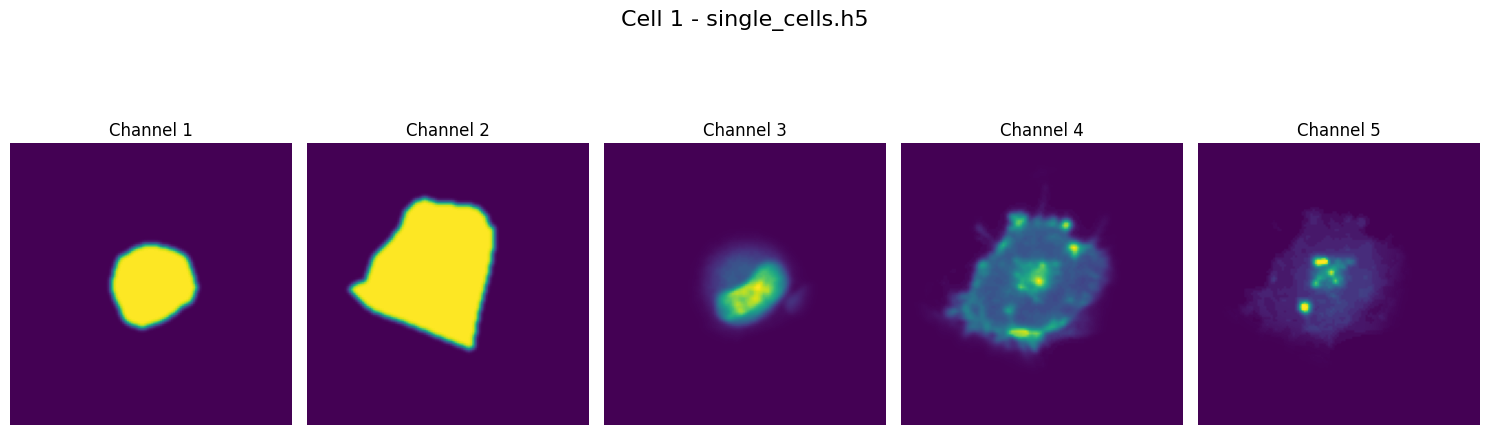

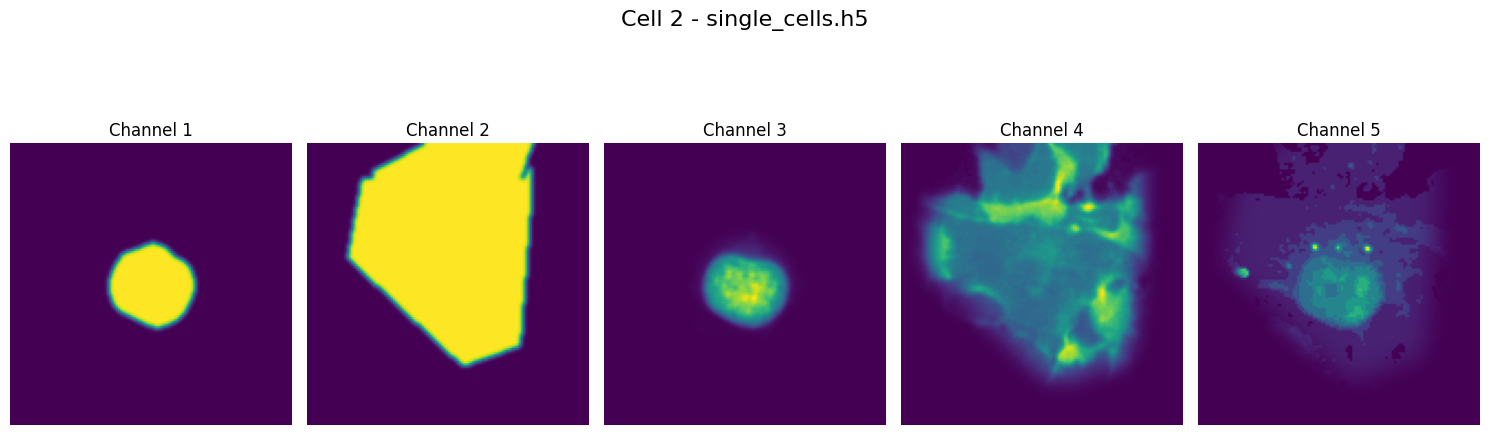

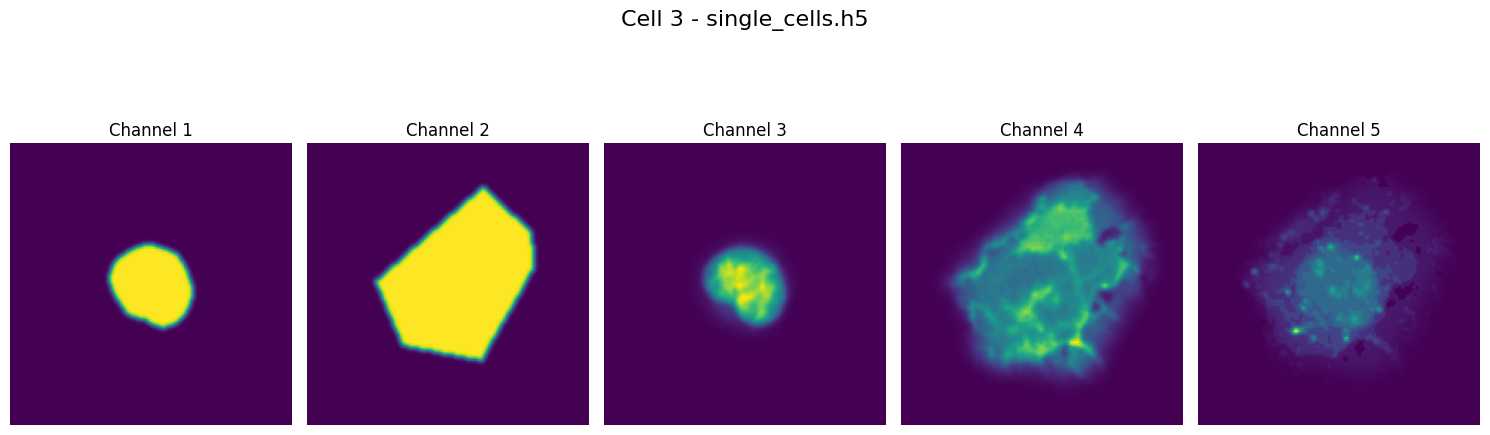

In [5]:
visualize_cells('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5', num_cells=3, channel_idx=None, randomize=False)

#### Display first 10 cellimages of channel 5 

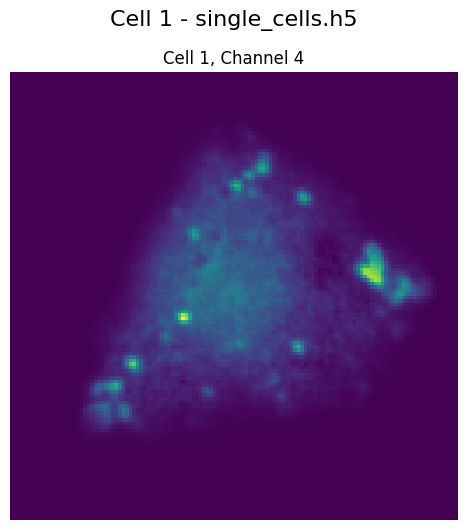

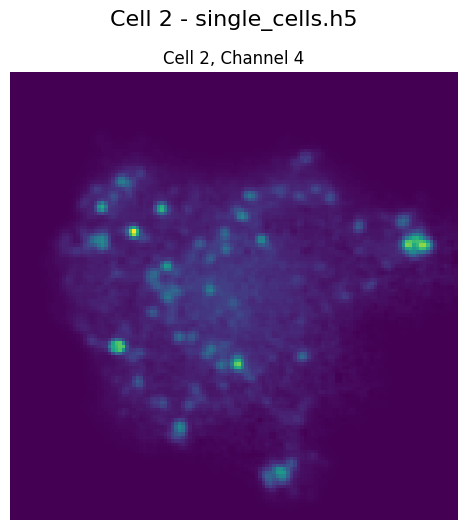

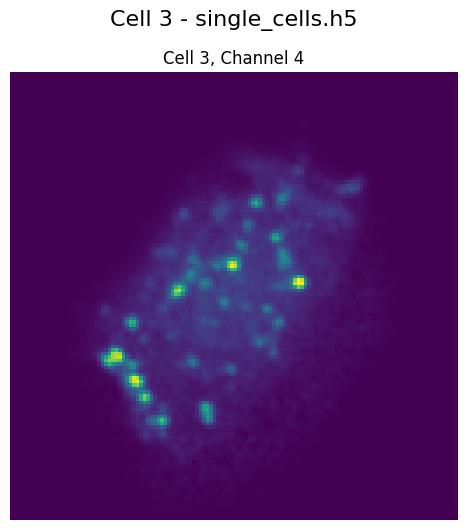

In [6]:
# Screening
visualize_cells('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', num_cells=3, channel_idx=4, randomize=False)

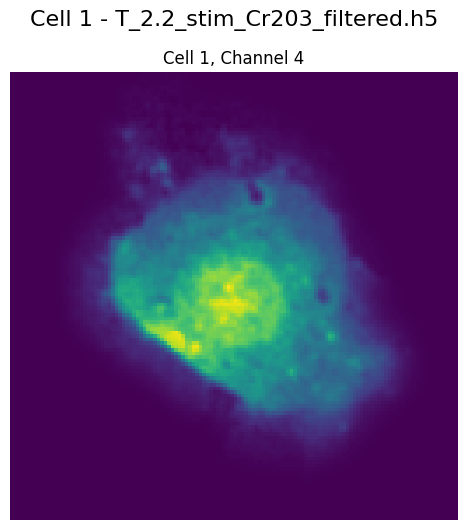

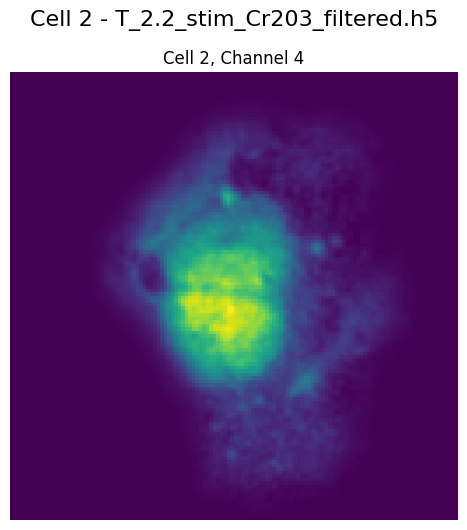

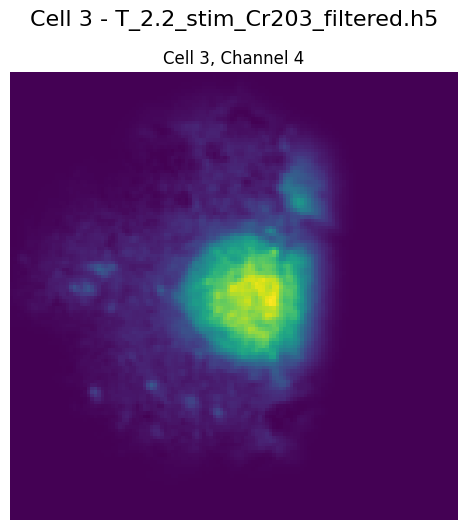

In [7]:
# ATG5 KO
visualize_cells('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5', num_cells=3, channel_idx=4, randomize=False)

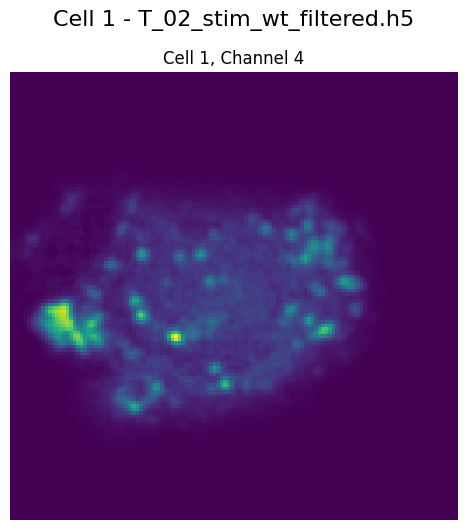

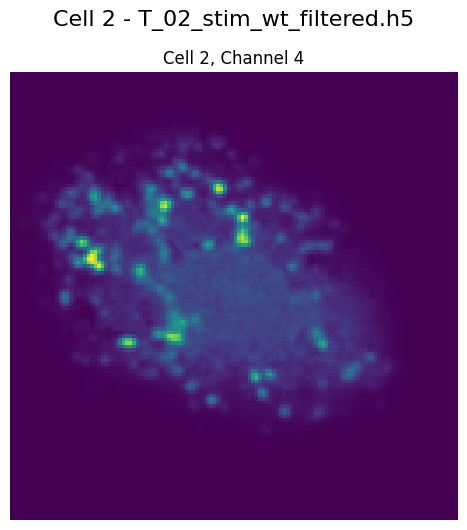

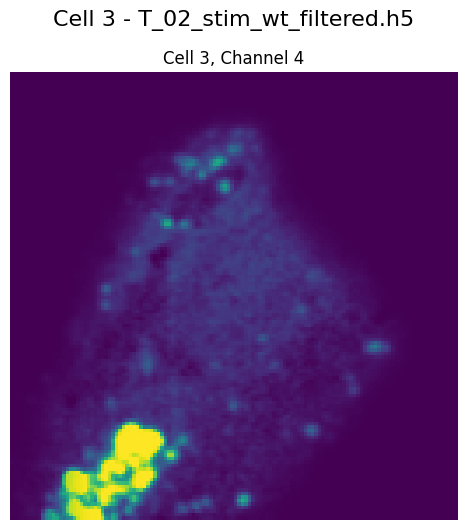

In [8]:
# Stim wt
visualize_cells('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5', num_cells=3, channel_idx=4, randomize=False)

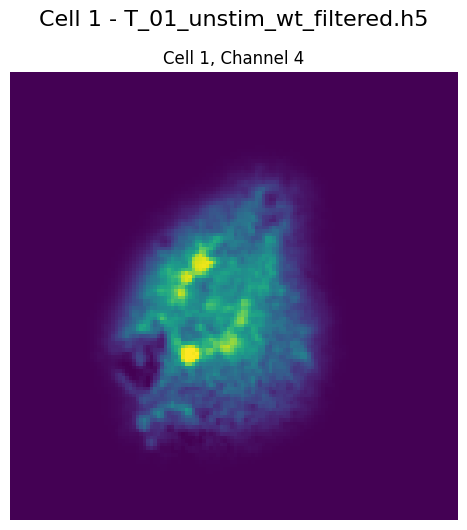

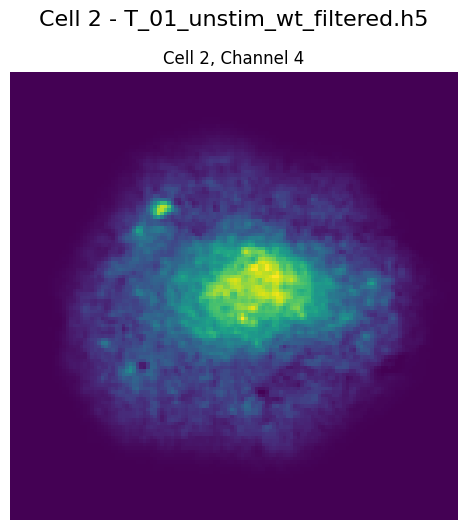

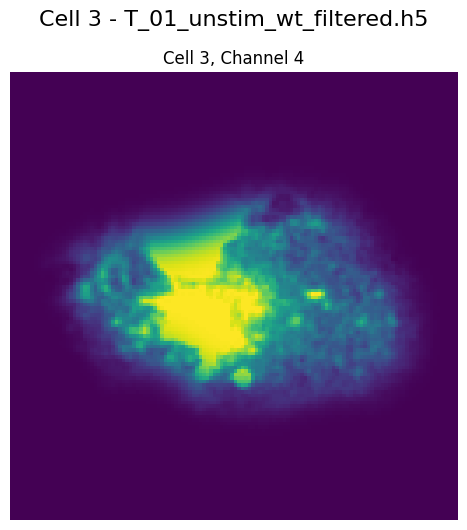

In [9]:
# Unstim
visualize_cells('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5', num_cells=3, channel_idx=4, randomize=False)

In [ ]:
# ...

## Final viualization per class

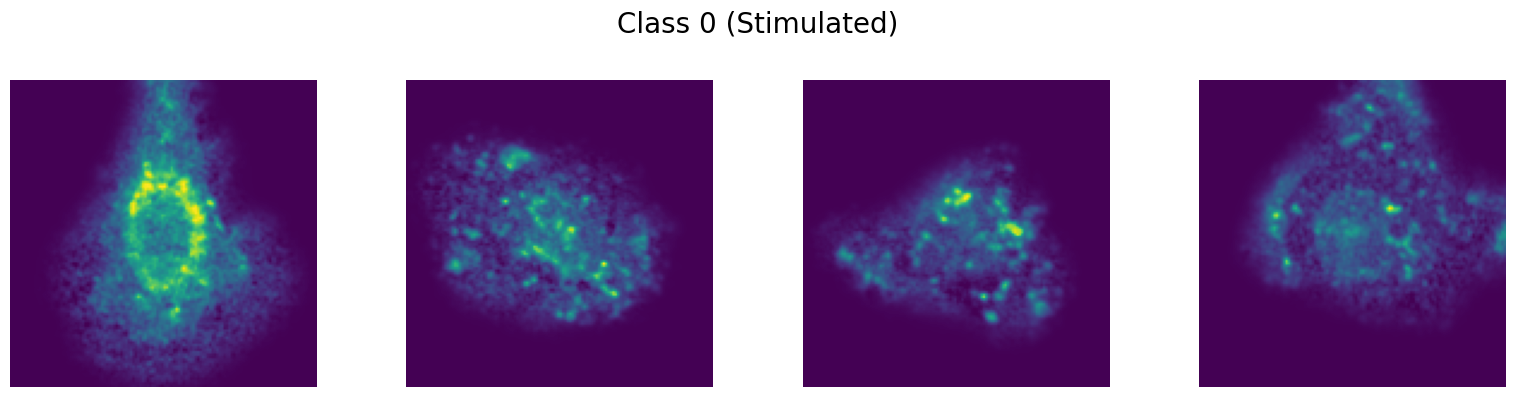

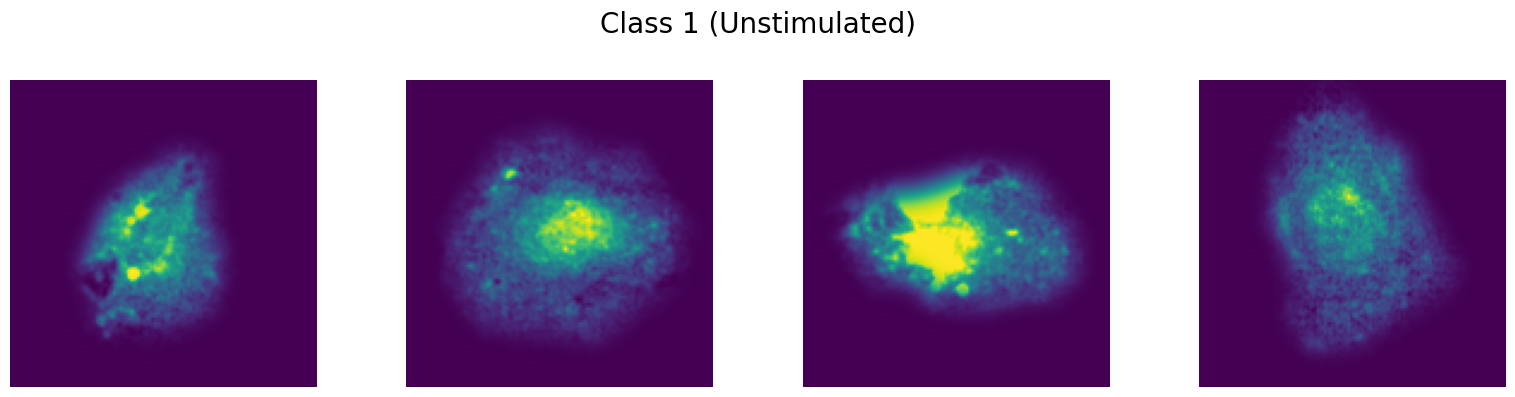

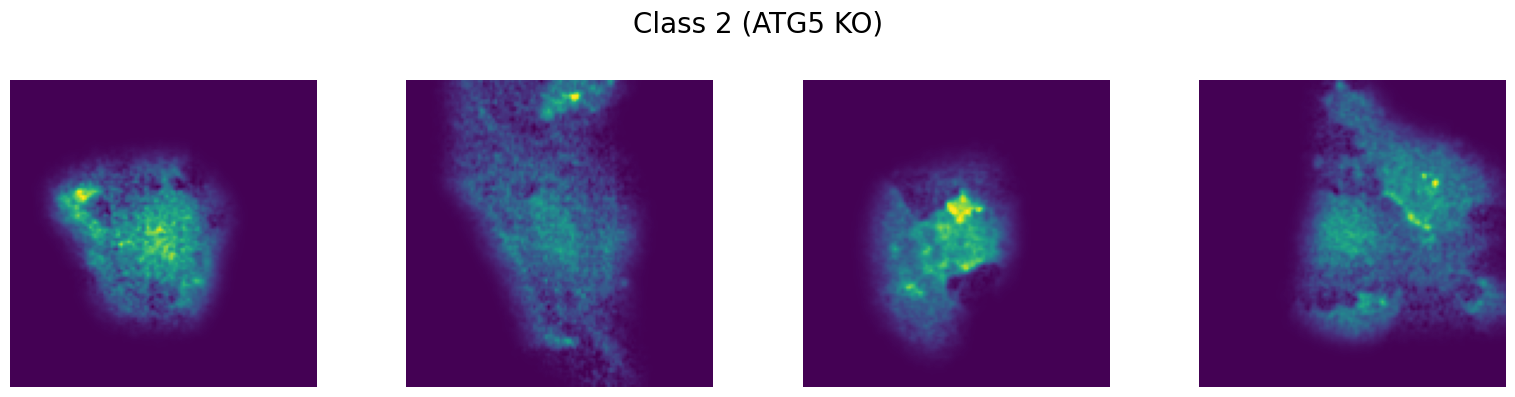

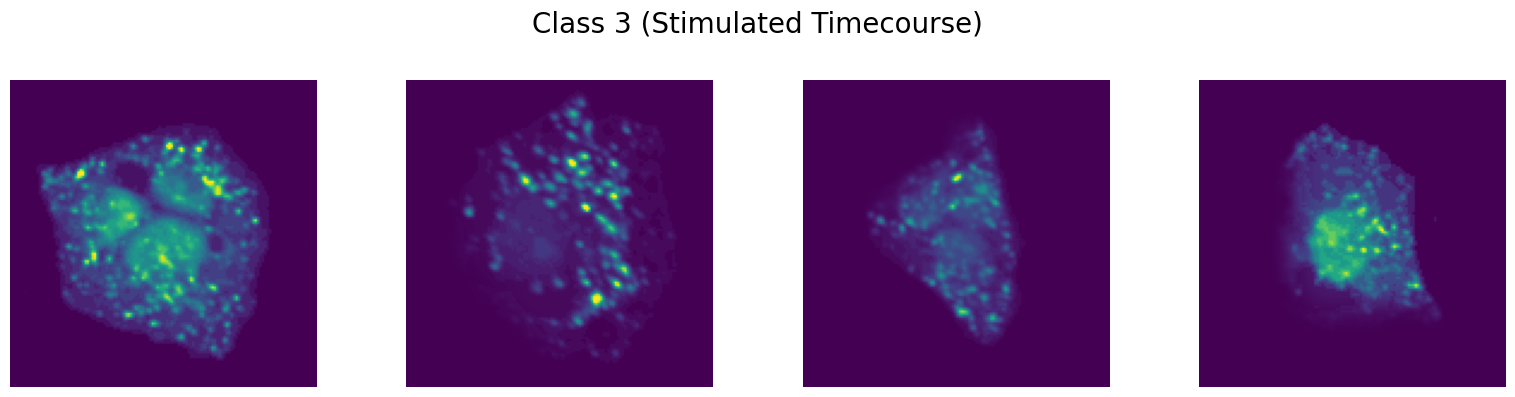

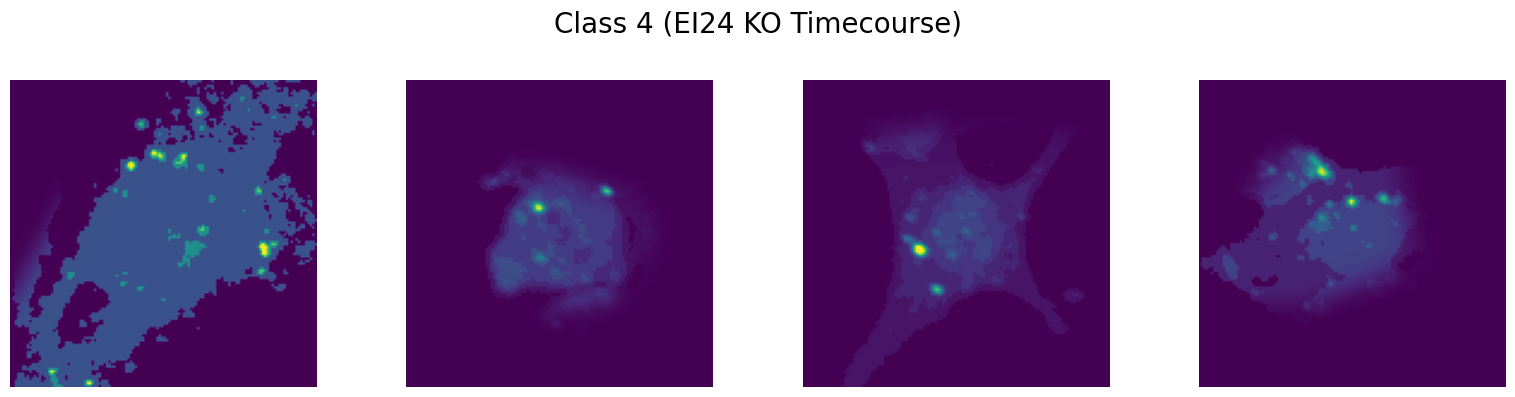

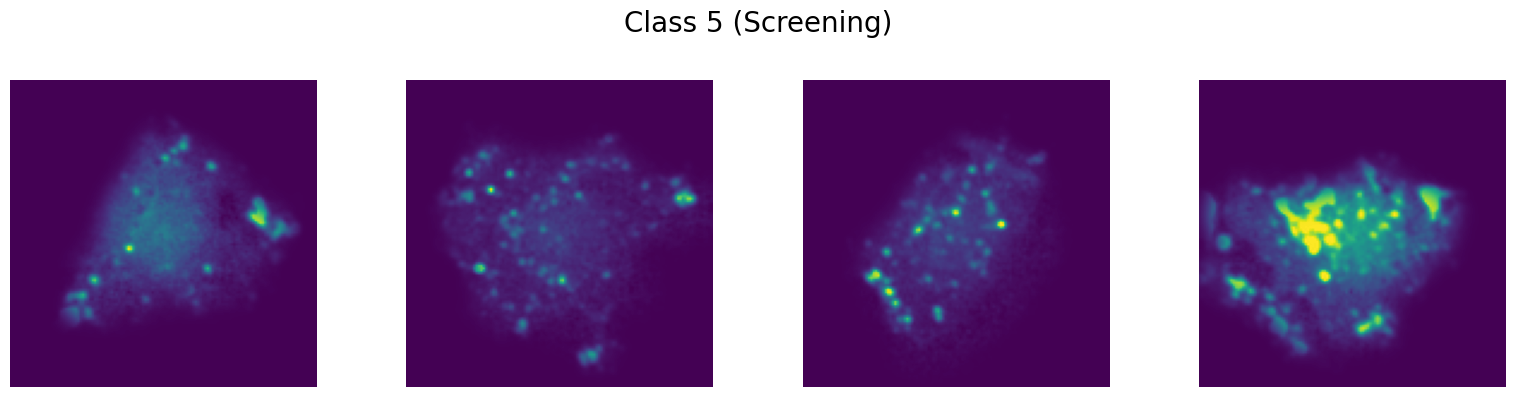

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

# Dictionary of class IDs, corresponding file paths, and titles
class_files = {
    0: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5", "Class 0 (Stimulated)"),
    1: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5", "Class 1 (Unstimulated)"),
    2: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5", "Class 2 (ATG5 KO)"),
    3: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5", "Class 3 (Stimulated Timecourse)"),
    4: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5", "Class 4 (EI24 KO Timecourse)"),
    5: ("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5", "Class 5 (Screening)"),
}

channel_idx = 4  # Image channel to visualize
save_fig = True  # Whether to save the figure
output_dir = "./figures/data_overview"
os.makedirs(output_dir, exist_ok=True)

for class_id, (file_path, class_title) in class_files.items():
    with h5py.File(file_path, 'r') as hdf5_file:
        if 'single_cell_data' not in hdf5_file:
            print(f"Skipping {file_path}: 'single_cell_data' not found.")
            continue

        data = hdf5_file['single_cell_data']
        num_cells = data.shape[0]
        num_to_show = min(4, num_cells)  # Show up to 4 images

        fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
        fig.suptitle(class_title, fontsize=20)

        for i in range(num_to_show):
            img = data[i, channel_idx, :, :]
            ax = axes[i] if num_to_show > 1 else axes
            ax.imshow(img, cmap='viridis')
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for title
        if save_fig:
            plt.savefig(os.path.join(output_dir, f"class_{class_id}.png"), dpi=300, bbox_inches='tight')
        plt.show()
